### Student Information
Name:孫槐駿

Student ID:110062466

GitHub ID:kstsunhj

Kaggle name:

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2021-Lab2-master Repo](https://github.com/fhcalderon87/DM2021-Lab2-master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/c/dm2021-lab2-hw2/) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 24th 11:59 pm, Friday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 29th 11:59 pm, Wednesday)__. 

In [1]:
### Begin Assignment Here

In [2]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [3]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [4]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)

<AxesSubplot:title={'center':'train_data'}, xlabel='text'>

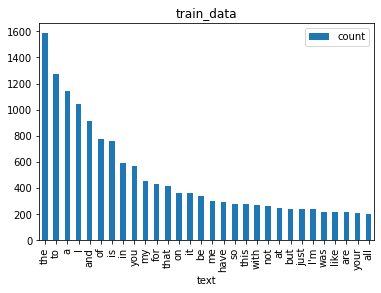

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
train_df_word = train_df.text.str.split()
train_tf_dfe = train_df_word.explode().to_frame().reset_index(drop=True)
dfg = train_tf_dfe.groupby('text').text.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(30).reset_index(drop=True)
dfg.plot.bar(x = 'text',y = 'count',title = 'train_data')

<AxesSubplot:title={'center':'test_data'}, xlabel='text'>

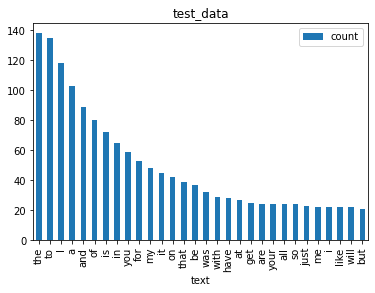

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
test_df_word = test_df.text.str.split()
test_tf_dfe = test_df_word.explode().to_frame().reset_index(drop=True)
dfg = test_tf_dfe.groupby('text').text.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(30).reset_index(drop=True)
dfg.plot.bar(x = 'text',y = 'count',title = 'test_data')

---

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_vectorizer = CountVectorizer() 
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

/home/kstsunhj/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3613, 500)

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
TFIDF_1000.fit(train_df['text'])
train_data_tfidf_features_1000 = TFIDF_1000.transform(train_df['text'])
feature_names_1000 = TFIDF_1000.get_feature_names()
feature_names_1000[100:110]

/home/kstsunhj/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc', 'bday', 'be']

---

In [10]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [11]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['sadness', 'anger', 'anger', 'anger', 'sadness', 'anger', 'joy',
       'sadness', 'fear', 'anger'], dtype=object)

In [12]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.99
testing accuracy: 0.66


In [13]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.64      0.69      0.67        84
        fear       0.65      0.67      0.66       110
         joy       0.68      0.66      0.67        79
     sadness       0.66      0.59      0.62        74

    accuracy                           0.66       347
   macro avg       0.66      0.65      0.66       347
weighted avg       0.66      0.66      0.66       347



In [14]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[58 16  6  4]
 [14 74 10 12]
 [ 9 11 52  7]
 [ 9 13  8 44]]


In [15]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

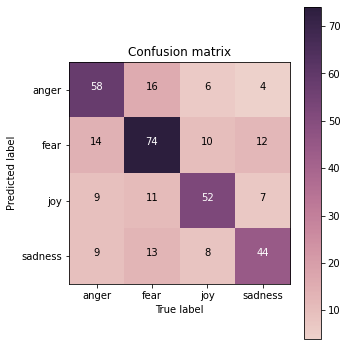

In [16]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

confusion matrix could show the true or false that the predicted label is. the 58 means true and predicted is both anger, the same as 74,52,44. 

16 means the predicted is anger, however, the true label is fear, which is false. The rest of number are just like this

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
train_x = list(train_df['text'])
train_y = list(train_df['emotion'])
test_x = list(test_df['text'])
test_y = list(test_df['emotion'])
GS_model = model.fit(train_x,train_y)
y_train_pred = GS_model.predict(train_x)
y_test_pred = GS_model.predict(test_x)
acc_train = accuracy_score(y_true=train_y, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=test_y, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.92
testing accuracy: 0.65


---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

---

Decision Tree model is better than Naive Bayes in this dataframe.

Decision Trees are very flexible, easy to understand, and easy to debug. They will work with classification problems and regression problems. It could be used to predict a categorical value. 

But Naive Bayes requires to build a classification by hand. What's more, Naive Bayes is hard to understand and classify data. However, it could help to predict the prohabilities like (A 90%, B 5%, C 2.5% D 2.5%).

---

In [18]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [19]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 1311       fear
3058    sadness
1746       fear
2356        joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


In [20]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


In [21]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

2021-12-20 16:11:53.001562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-20 16:11:53.001639: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-20 16:11:53.002265: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

In [22]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


/home/kstsunhj/.local/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


113/113 [==============================] - 2s 5ms/step - loss: 1.3201 - accuracy: 0.3786 - val_loss: 1.2696 - val_accuracy: 0.4524
Epoch 2/25
113/113 [==============================] - 0s 4ms/step - loss: 0.9889 - accuracy: 0.6488 - val_loss: 0.9412 - val_accuracy: 0.6455
Epoch 3/25
113/113 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.7944 - val_loss: 0.8192 - val_accuracy: 0.7089
Epoch 4/25
113/113 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8550 - val_loss: 0.8101 - val_accuracy: 0.7003
Epoch 5/25
113/113 [==============================] - 0s 3ms/step - loss: 0.3322 - accuracy: 0.8838 - val_loss: 0.8478 - val_accuracy: 0.6916
Epoch 6/25
113/113 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.9117 - val_loss: 0.9301 - val_accuracy: 0.6715
Epoch 7/25
113/113 [==============================] - 0s 4ms/step - loss: 0.2208 - accuracy: 0.9338 - val_loss: 1.0060 - val_accuracy: 0.6599
Epoch 8/25
113/11

In [23]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

array([[6.8321437e-02, 3.6900868e-03, 5.1924493e-04, 9.2746925e-01],
       [9.6522927e-01, 1.4675254e-02, 6.9937813e-03, 1.3101603e-02],
       [3.2437590e-01, 4.8009846e-02, 5.7637781e-01, 5.1236428e-02],
       [7.8585267e-01, 9.4618008e-06, 2.0135947e-01, 1.2778367e-02],
       [3.9636772e-05, 1.4560348e-07, 1.9537963e-04, 9.9976486e-01]],
      dtype=float32)

In [24]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['sadness', 'anger', 'joy', 'anger', 'sadness'], dtype=object)

In [25]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.63


In [26]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.378633,1.320079,0.452450,1.269595
1,1,0.648768,0.988850,0.645533,0.941222
2,2,0.794354,0.594717,0.708934,0.819220
3,3,0.854968,0.417553,0.700288,0.810100
4,4,0.883753,0.332219,0.691643,0.847843
5,5,0.911708,0.266750,0.671470,0.930118
6,6,0.933850,0.220762,0.659942,1.006015
7,7,0.941323,0.179886,0.657061,1.069476
8,8,0.951564,0.156874,0.648415,1.110749
9,9,0.957653,0.133915,0.657061,1.144023


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below (Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

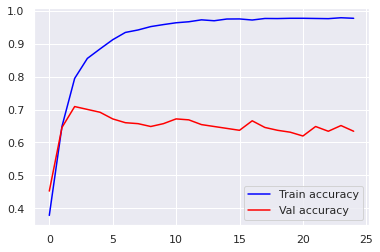

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plt.plot(training_log.accuracy, 'blue', label='Train accuracy')
plt.plot(training_log.val_accuracy,'red', label='Val accuracy')
plt.legend()
plt.show()

Accuracy means the accuracy of what was trained against. Val_accuracy refers to validation set. The val accuracy lower than accuracy is normal. And if the validation accuracy is much lower than accuracy, you are certainly over fitting.

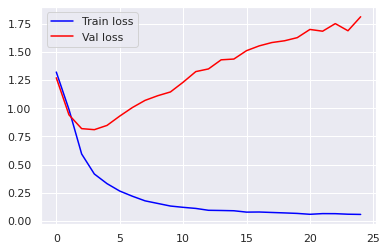

In [28]:
plt.plot(training_log.loss, 'blue', label='Train loss')
plt.plot(training_log.val_loss,'red', label='Val loss')
plt.legend()
plt.show()

Loss means the loss of what was trained against. Val_loss is validation loss set. If train loss decrease and test loss decrease, which means the model is still learning. If train loss decrease, test loss not change, which means it is over fitting. If train loss do not change, test loss decreases, which means the data set has some problem. If trian loss do not change, test loss do not change too, which means we should decrease the training rate. If train loss increase and test loss increase, which means there has some problems in data set. 

---

In [99]:
## check library
import gensim
from gensim.models import Word2Vec

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
## setting
vector_dim = 100
window_size = 5
min_count = 1
training_iter = 20
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()
training_corpus = train_df['text_tokenized'].values

In [30]:
## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_iter)
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[('blessed', 0.9123809933662415),
 ('cats', 0.9091066718101501),
 ('help', 0.9072853326797485),
 ('birthday', 0.9069467782974243),
 ('Be', 0.9061015844345093),
 ('free', 0.9040145874023438),
 ("'you", 0.8963281512260437),
 ('smile', 0.8920209407806396),
 ('Really', 0.8917237520217896),
 ('angry', 0.8905168175697327)]

In [31]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [32]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

In [33]:
glove_twitter_25_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


In [78]:
training_corpus_num = training_corpus.copy()

In [104]:
for r in range(len(training_corpus)):
    for i in range(len(training_corpus[r])):
        training_corpus_num[r][i] = word2vec_model.wv.key_to_index[training_corpus[r][i]]

In [119]:
training_corpus_num

array([list([1, 3599, 1, 3597, 1, 3593, 3589, 11, 3587, 3, 3583, 4, 1197, 6, 12, 621, 19, 19, 19, 4, 92, 24, 16, 102, 168, 622, 0, 235]),
       list([1, 3581, 130, 245, 8, 961, 239, 2]),
       list([4, 110, 18, 3579, 223]), ...,
       list([1, 10368, 325, 3996, 227, 10, 2110, 811, 2, 4, 31, 267, 44, 17, 1160, 6926]),
       list([567, 5, 3, 1985, 20, 2324, 15, 832, 284, 431, 2]),
       list([127, 1068, 36, 13, 7, 504, 1669, 43, 4, 31, 92, 491, 7, 310, 43, 148, 218, 36, 68, 808, 189, 8, 26, 36, 3, 3338, 21, 3, 1408, 43, 0, 170])],
      dtype=object)

In [118]:

word2vec_model.wv.index_to_key

['#',
 '@',
 '.',
 'the',
 'I',
 ',',
 'to',
 'a',
 'and',
 '!',
 'is',
 'of',
 'you',
 'in',
 'it',
 "'s",
 "n't",
 'that',
 'my',
 '?',
 'for',
 'on',
 'me',
 'be',
 'have',
 'so',
 'this',
 'do',
 "'",
 'not',
 'with',
 "'m",
 ';',
 'at',
 'but',
 'just',
 'was',
 'like',
 'are',
 'i',
 '&',
 'all',
 'your',
 '...',
 'about',
 ':',
 'amp',
 'from',
 'by',
 'out',
 'up',
 'get',
 'if',
 'when',
 'he',
 'will',
 'they',
 'can',
 'as',
 'we',
 'The',
 'what',
 ')',
 '-',
 'or',
 'one',
 'It',
 'no',
 'an',
 'now',
 "'re",
 'time',
 'day',
 'know',
 'there',
 'people',
 'our',
 'his',
 'has',
 'who',
 'would',
 'her',
 'more',
 'how',
 'good',
 'think',
 'did',
 'go',
 '..',
 'love',
 "'ve",
 'u',
 'still',
 'make',
 'got',
 'she',
 'You',
 'ca',
 'been',
 'want',
 '(',
 'him',
 'had',
 'over',
 'their',
 'today',
 'back',
 'only',
 'some',
 'feel',
 'lost',
 'happy',
 'off',
 'them',
 'should',
 'really',
 'too',
 'amazing',
 'see',
 "'ll",
 'way',
 'We',
 'need',
 'because',
 'life',


In [108]:
word2vec_model.wv.key_to_index['happy']

111

In [111]:
word2vec_model_num = Word2Vec(sentences=training_corpus_num, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_iter)

In [124]:
word_vec_num = word2vec_model_num.wv[word2vec_model.wv.key_to_index['happy']]
# Get the most similar words
word = word_vec_num
topn = 10
for r in range(10):
    print(word2vec_model.wv.index_to_key[word2vec_model_num.wv.most_similar(word, topn=topn)[r][0]])

happy
blessed
Be
O
'you
help
smile
🕋
birthday
play


In [117]:
word2vec_model.wv.index_to_key[7029]

'muslims'

In [34]:
train_df[['text_tokenized']]

,text_tokenized
1311,"[@, AOLUK, @, JamesHayr, @, TheDrum, Anychance..."
3058,"[@, deshbhakthoon, always, unhappy, and, easil..."
1746,"[I, lost, my, blinders, ....]"
2356,"[15, minutes, of, yoga, to, your, breakfast, r..."
3159,"[Regret, for, the, things, we, did, can, be, t..."
...,...
257,"[OOOOOOOOH, MY, GOD, UUUUGGGGHHHHHHHHH, #, rage]"
1807,"[They, used, to, laugh, at, her, coz, she, cou..."
152,"[@, RobertTaitWHU, against, Chelsea, anything,..."
762,"[Well, ,, the, lines, for, Sweden, 's, goals, ..."


---

In [35]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


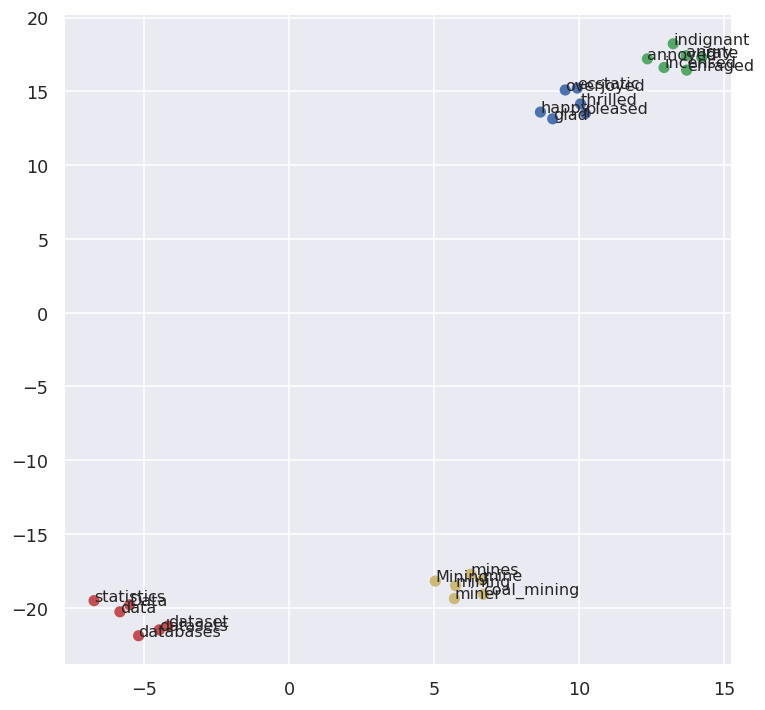

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.key_to_index.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

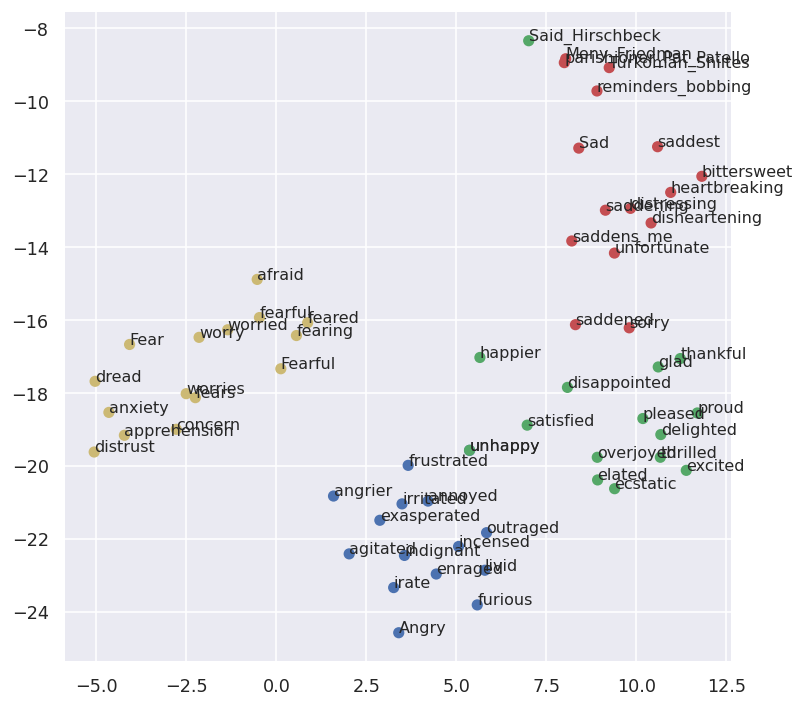

In [37]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
happy_words = [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
angry_words = [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]        
data_words = [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
mining_words = [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]  
target_words = happy_words + angry_words + data_words + mining_words
cn = topn
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.key_to_index.keys())
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()